# Introduction

The following documents observations in the varying strengths and weaknesses of five machine learning algorithms; Decision Trees, K-Nearest Neighbors, Support Vector Machines, Boosting and Neural Networks. 

We compared the algorithms by testing their performance on classifying results for three unique datasets. By adjusting model hyperparameters, we were able to observe changes in performance using validation curves, learning curves, wall-clock time and loss curves where applicable. The analysis was performed in python 3.7 using the scikit-learn (sklearn) package, version 1.2.1.

Imports:

In [17]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import time

# random seed
np.random.seed(42)

# font size for plots
fs=22

# Get the data

Load datasets from openml with sklearn

- [bioresponse_data](https://www.openml.org/search?type=data&status=active&sort=nr_of_likes&qualities.NumberOfFeatures=between_1000_10000&id=4134): Binary classification of whether (1) or not (0) a molecule will elicit a biological response based on various molecular features. 3751 records, 1777 features, 2 classes. All numeric, none missing. Balanced (47%)
- [letter_data](https://www.openml.org/search?type=data&status=active&sort=nr_of_likes&qualities.NumberOfFeatures=gte_0&qualities.NumberOfInstances=between_10000_100000&qualities.NumberOfClasses=gte_2&id=6):  20000 records, 17 features, 26 classes. 16 numeric, 1 symbolic, none missing. Also pretty well balanced (586/1600=0.03666/0.04166=0.879)

In [18]:
from sklearn import datasets
bio_data = sklearn.datasets.fetch_openml(data_id = 4134, target_column=None, parser='auto')['data']
letter_data = sklearn.datasets.fetch_openml(data_id = 6, target_column=None, parser='auto')['data']

# Preprocessing

These datasets are normalized and fairly clean, so the only processing we will cover before training our models training our models is:
- Train/test split with sklearn.model_selection.[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- Label encoding with sklearn.preprocessing.[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)
- X/y split

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# split into train/test sets
bio_train, bio_test = train_test_split(bio_data, test_size=0.2, random_state=42)
letter_train, letter_test = train_test_split(letter_data, test_size=0.2, random_state=42)

# encode label for letter data
ordinal_encoder = OrdinalEncoder(categories = [['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']])
letter_train['class'] = ordinal_encoder.fit_transform(letter_train[['class']])
letter_test['class'] = ordinal_encoder.fit_transform(letter_test[['class']])

# split x and y for test and train sets
bio_train_x, bio_train_y = bio_train.drop('target', axis=1), bio_train['target'].astype('int')
letter_train_x, letter_train_y = letter_train.drop('class', axis=1), letter_train['class']

bio_test_x, bio_test_y = bio_test.drop('target', axis=1), bio_test['target'].astype('int')
letter_test_x, letter_test_y = letter_test.drop('class', axis=1), letter_test['class']

## Performance Metrics

The use case of our bioresponse model would be in the pharmaceutical industry where molecular components are chosen for synthesis to form greater compounds, in which case an engineer would choose only components that elicit the firing, or positive, response. The primary concern in this workflow is false positives, so we measured the performance of the results using precision.

Our letter data is a multi-class dataset, so our goal was to look at the classifiers ability to differentiate between class labels while maintaining a reduction in error of all positive and negative outcomes. To achieve this goal, we looked at Matthew's Correlation Coefficient and Area Under the Reciever Operating Characteristic (ROC) Curve.

In [20]:
# precision scorer for binary bioresponse data
precision_scoring=['Precision', 'precision']

# matthew correlation and ROC AUC for multi-class letter data
mcc_scoring=['Matthew Correlation Coefficient', 'matthews_corrcoef']
rocauc_scoring=['ROC AUC', 'roc_auc_ovo']

### Cross Validation and Evaluation Curves

Below are a few helper functions for plotting our curves to analyze bias and variance

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_validation_curve(classifier, X, y, param_name, param_range, scoring, ax=None, cv=5, fs=22,lw=2):
    
    # timed cross-validation curve scores
    start = time.time()
    train_scores,test_scores = validation_curve(
        classifier, X, y, param_name=param_name[1], param_range=param_range,
        scoring=scoring[1], cv=cv)
    print(f'{param_name[0]} time: {time.time() - start}')
    
    if ax != None:
        # pass data to plotting function
        just_plot(train_scores, test_scores, param_name[0], param_range, ax=ax)

        # set x axis limit
        ax.set_xlim(param_range[0],param_range[-1])
        
    return [train_scores, test_scores]

In [22]:
def plot_learning_curve(classifier, X, y, scoring, ax=None, train_sizes_pct = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], jobs=4, fs=22, lw=2):
    
    # learning curve parameters
    common_params = {
        "X": X,
        "y": y,
        "train_sizes": train_sizes_pct,
        "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
        "scoring" : scoring[1],
        "n_jobs": jobs,
        "return_times": True
    }

    # timed learning curve scores
    start = time.time()
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        classifier, **common_params
    )
    print(f'Learning curve time: {time.time() - start}')
    
    if ax != None:
        # pass data to plotting function
        just_plot(train_scores, test_scores, 'Number of Samples (%)', train_sizes, ax=ax)
        
        # plot x axis parameters
        ax.set_xticks(train_sizes)
        ax.set_xticklabels([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
        ax.set_xlim(train_sizes[0],train_sizes[-1])

    
    return [train_sizes, train_scores, test_scores, fit_times, score_times]

In [23]:
def just_plot(train_scores, test_scores, param_name, param_range, ax, fs=22, lw=2):
    # calculate mean and standard deviation of multiple runs for train and test data
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # plot training data
    ax.plot(param_range,train_mean, label=f'Training Set', color='darkorange',lw=lw)

    ax.set_xlabel(param_name, fontsize=fs+2)
    if type(param_range[0]) != str:
        ax.set_xlim((min(param_range),max(param_range)))
        ax.set_xticks(list(ax.get_xticks())+[min(param_range)])

    ax.fill_between(
        param_range,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )

    # plot test/validation data
    ax.plot(param_range,test_mean, label=f'Validation Set', color='navy',lw=lw)

    ax.fill_between(
        param_range,
        test_mean - test_std,
        test_mean + test_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )

    # additional plotting parameters
    ax.tick_params(axis='both', which='major', labelsize=fs)
    ax.grid()

# Decision Trees

Using sklearn.tree.[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

In [25]:
from sklearn.tree import DecisionTreeClassifier

# initial hyperparameter ranges
dt_md_name=['Max Depth', 'max_depth']
dt_md_range=range(2,21)

dt_msl_name = ['Minimum Samples Leaf', 'min_samples_leaf']
dt_msl_range = range(1,51)

dt_mss_name = ['Minimum Samples Split', 'min_samples_split']
dt_mss_range = range(2,31)

## Bioresponse Curves

Max Depth time: 32.94449830055237
Minimum Samples Leaf time: 188.13049840927124
Minimum Samples Split time: 78.40099883079529
Minimum Samples Split time: 35.14999985694885
Learning curve time: 47.87647604942322
Learning curve time: 24.943585634231567


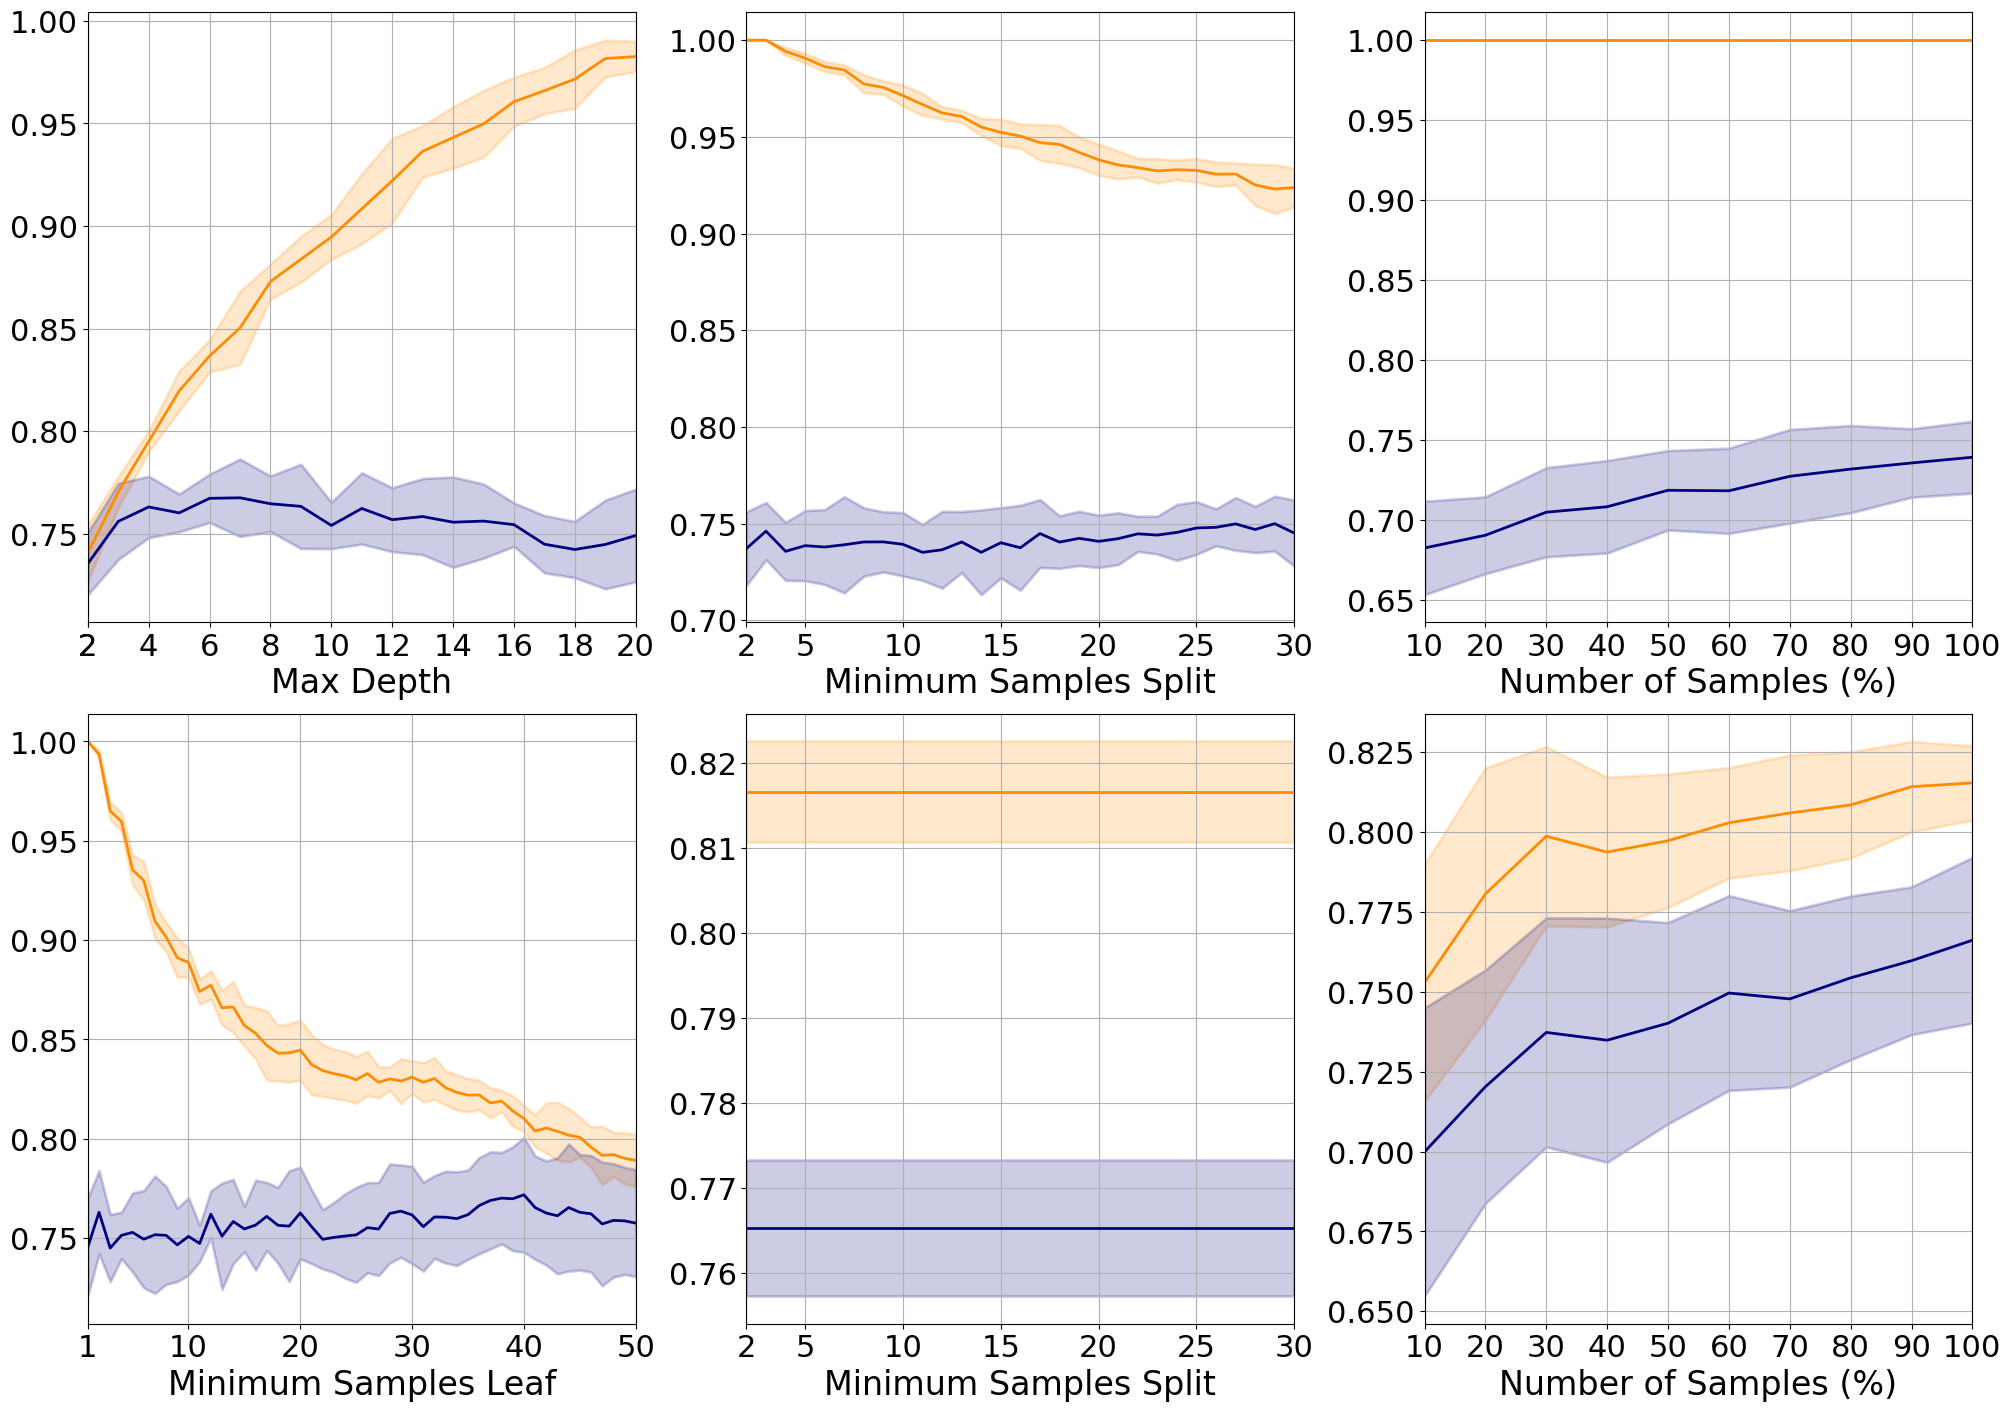

In [26]:
# initialize plot
bio_fig, bio_axs = plt.subplots(2, 3, constrained_layout=True)
bio_fig.set_size_inches(20, 14)

# maximum depth
dt_bio_vc_depth = plot_validation_curve(DecisionTreeClassifier(random_state=42), 
                                        bio_train_x, bio_train_y, param_name=dt_md_name, param_range=dt_md_range, scoring=precision_scoring, ax=bio_axs[0,0])

# minimum samples per leaf
dt_bio_vc_msl = plot_validation_curve(DecisionTreeClassifier(random_state=42), 
                                      bio_train_x, bio_train_y, param_name=dt_msl_name, param_range=dt_msl_range, scoring=precision_scoring, ax=bio_axs[1,0], cv=10)

# minimum samples per split
dt_bio_vc_mss = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                      bio_train_x, bio_train_y, param_name=dt_mss_name, param_range=dt_mss_range, scoring=precision_scoring, ax=bio_axs[0,1])
dt_bio_vc_mss = plot_validation_curve(DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_leaf=29), 
                                      bio_train_x, bio_train_y, param_name=dt_mss_name, param_range=dt_mss_range, scoring=precision_scoring, ax=bio_axs[1,1])

# learning curves
dt_bio_lc = plot_learning_curve(DecisionTreeClassifier(random_state=42), 
                                bio_train_x, bio_train_y, precision_scoring, ax=bio_axs[0,2])
dt_bio_lc_tuned = plot_learning_curve(DecisionTreeClassifier(random_state=42, max_depth=7, min_samples_leaf=29), 
                                      bio_train_x, bio_train_y, precision_scoring, ax = bio_axs[1,2])

### Plot

In [28]:
# titles
bio_fig.suptitle('Bioresponse Curves for Decision Tree Classifier',fontsize=fs+4)
bio_axs[0,0].set_title('(a)',fontsize=fs+2)
bio_axs[0,1].set_title('(b)',fontsize=fs+2)
bio_axs[0,2].set_title('(c)',fontsize=fs+2)
bio_axs[1,0].set_title('(d)',fontsize=fs+2)
bio_axs[1,1].set_title('(e)',fontsize=fs+2)
bio_axs[1,2].set_title('(f)',fontsize=fs+2)

# x axis limits
bio_axs[0,1].set_xlabel(None)
bio_axs[0,2].set_xlabel(None)

# y axis limits and labels
plt.setp(bio_axs, ylim=[0.6,1.005])
bio_axs[0,0].set_ylabel('Precision', fontsize=fs+2)
bio_axs[1,0].set_ylabel('Precision', fontsize=fs+2)
bio_axs[0,1].tick_params(labelleft=False, left=False)
bio_axs[0,2].tick_params(labelleft=False, left=False)
bio_axs[1,1].tick_params(labelleft=False, left=False)
bio_axs[1,2].tick_params(labelleft=False, left=False)

# legend and save
bio_axs[0,2].legend(loc="best", fontsize=fs)
plt.show()

## Letter Curves

Max Depth time: 7.064499855041504
Max Depth time: 72.07400107383728
Minimum Samples Leaf time: 7.25850248336792
Minimum Samples Leaf time: 76.19349956512451
Learning curve time: 4.96104884147644
Learning curve time: 63.78959012031555


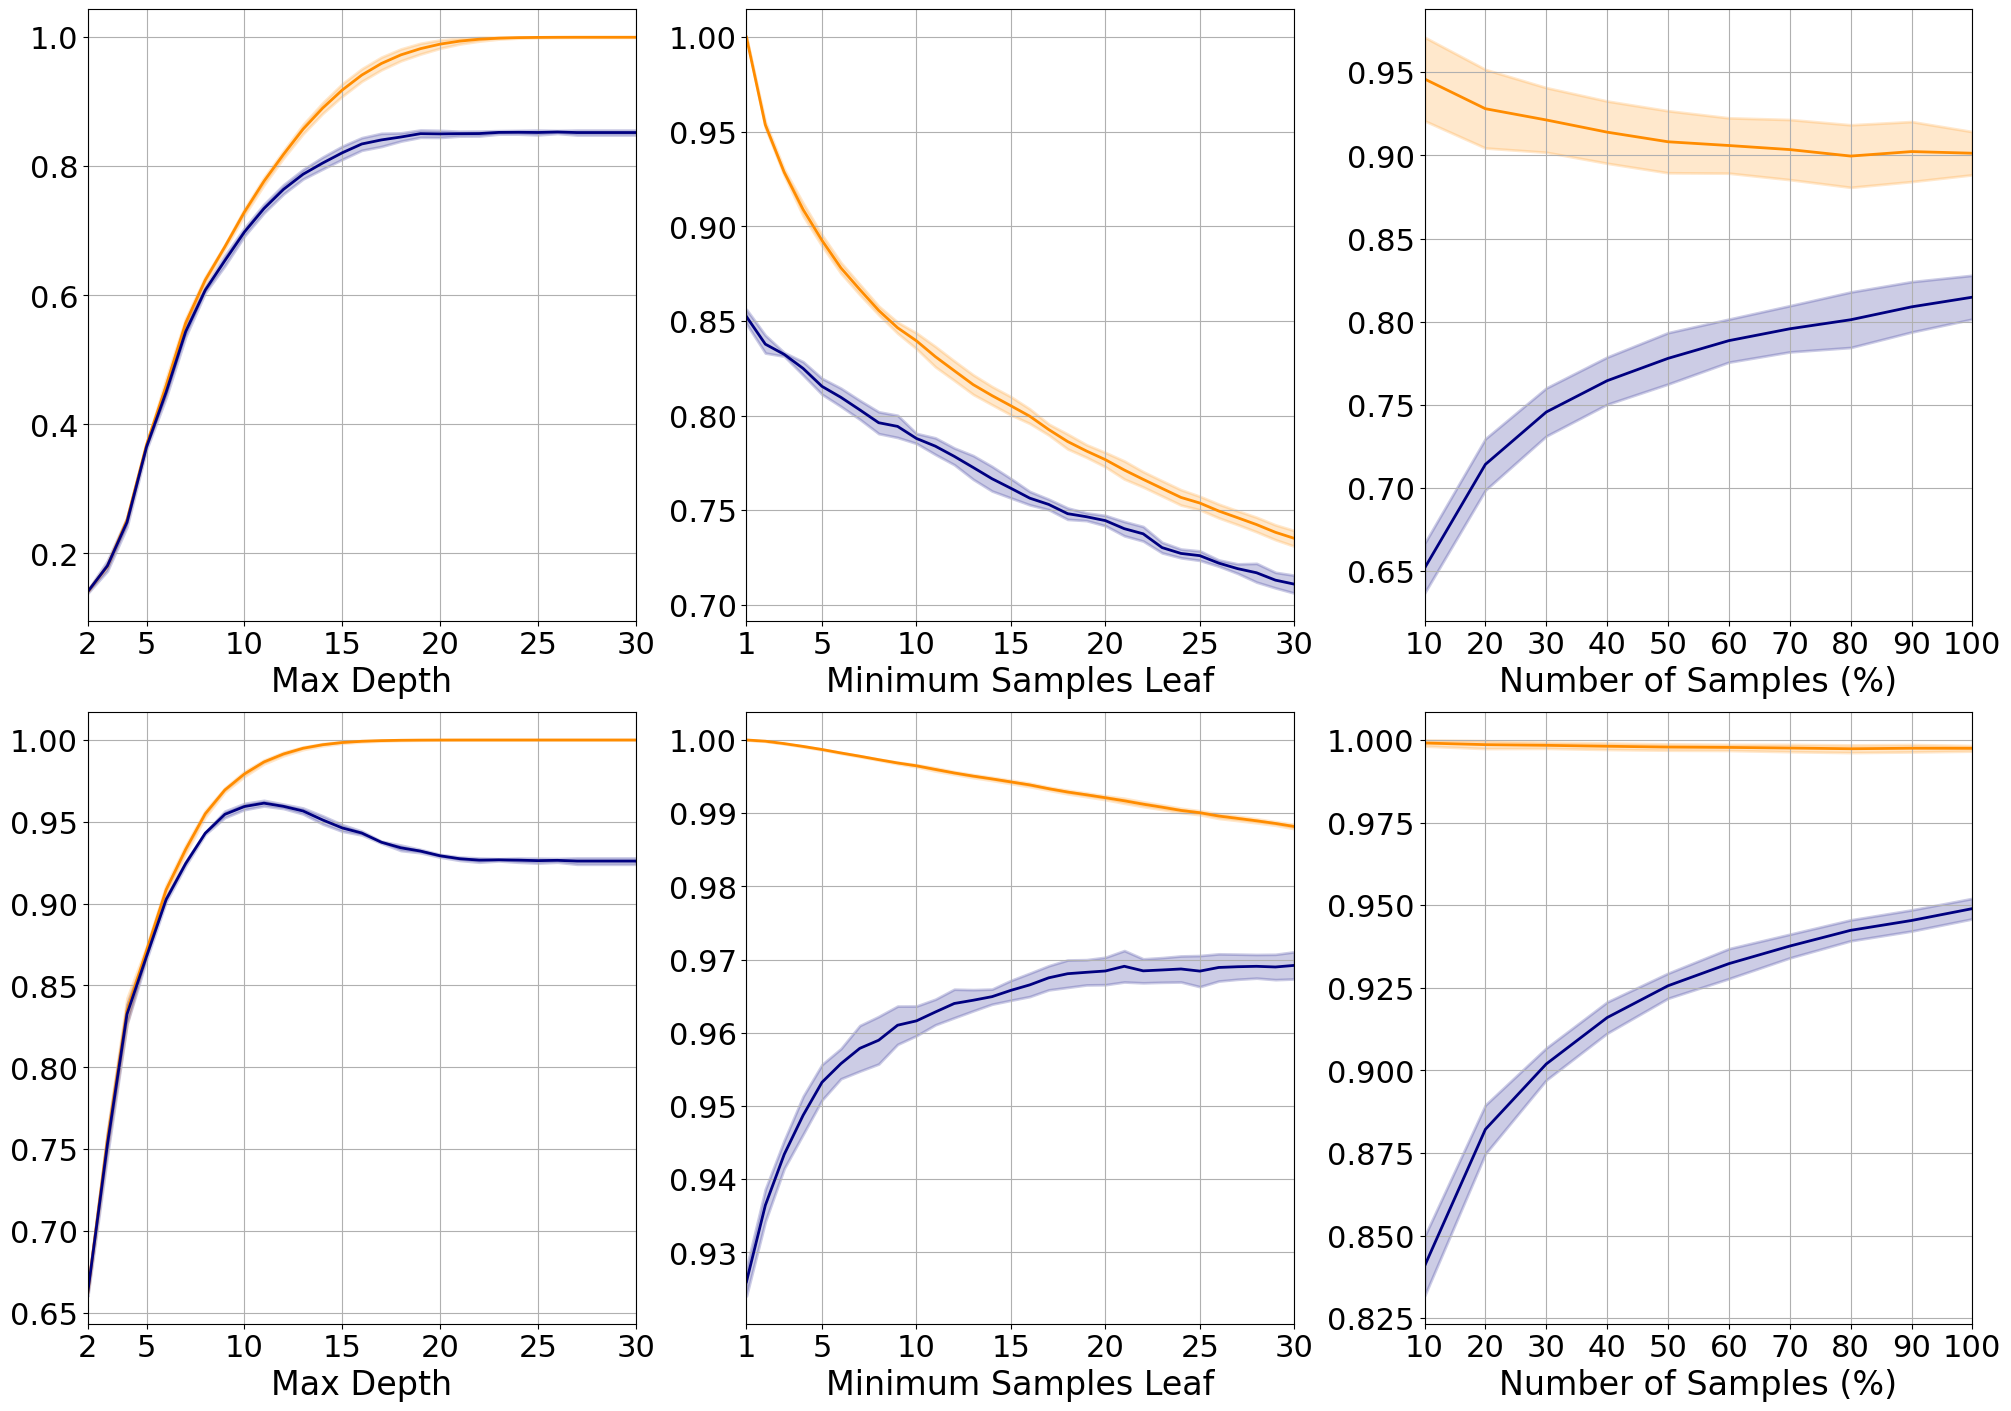

In [30]:
# initialize plot
letter_fig, letter_axs = plt.subplots(2, 3, constrained_layout=True)
letter_fig.set_size_inches(20, 14)

# max depth
dt_md_range = range(2,31)
dt_letter_depth = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                           letter_train_x, letter_train_y, param_name=dt_md_name, param_range=dt_md_range, scoring=mcc_scoring, ax=letter_axs[0, 0])
dt_letter_depth_roc = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                               letter_train_x, letter_train_y, param_name=dt_md_name, param_range=dt_md_range, scoring=rocauc_scoring, ax=letter_axs[1, 0])

# minimum samples per leaf
dt_msl_range=range(1,31)
dt_letter_msl = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                         letter_train_x, letter_train_y, param_name=dt_msl_name, param_range=dt_msl_range, scoring=mcc_scoring, ax=letter_axs[0, 1])
dt_letter_msl_roc = plot_validation_curve(DecisionTreeClassifier(random_state=42),
                                             letter_train_x, letter_train_y, param_name=dt_msl_name, param_range=dt_msl_range, scoring=rocauc_scoring, ax=letter_axs[1, 1])

# learning curve
dt_letter_lc_tuned = plot_learning_curve(DecisionTreeClassifier(random_state=42, max_depth=15), letter_train_x, letter_train_y, mcc_scoring, ax=letter_axs[0, 2])
dt_letter_lc_roc_tuned = plot_learning_curve(DecisionTreeClassifier(random_state=42, max_depth=15), letter_train_x, letter_train_y, rocauc_scoring, ax=letter_axs[1, 2])

### Plot

In [233]:
# titles
letter_fig.suptitle('Letter Curves for Decision Tree Classifier',fontsize=fs+4)
letter_axs[0,0].set_title('(a)',fontsize=fs+2)
letter_axs[0,1].set_title('(b)',fontsize=fs+2)
letter_axs[0,2].set_title('(c)',fontsize=fs+2)
letter_axs[1,0].set_title('(d)',fontsize=fs+2)
letter_axs[1,1].set_title('(e)',fontsize=fs+2)
letter_axs[1,2].set_title('(f)',fontsize=fs+2)

# x labels
letter_axs[0,0].set_xlabel(None)
letter_axs[0,1].set_xlabel(None)
letter_axs[0,2].set_xlabel(None)

# y limits and labels
letter_axs[0,0].set_ylim((0.6,1.005))
letter_axs[0,1].set_ylim((0.6,1.005))
letter_axs[0,2].set_ylim((0.6,1.005))
letter_axs[1,0].set_ylim((0.8,1.005))
letter_axs[1,1].set_ylim((0.8,1.005))
letter_axs[1,2].set_ylim((0.8,1.005))
letter_axs[0,0].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
letter_axs[1,0].set_ylabel('Area Under ROC Curve', fontsize=fs+2)
letter_axs[0,0].tick_params(labelbottom=False, bottom=False)
letter_axs[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
letter_axs[0,2].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
letter_axs[1,1].tick_params(labelleft=False, left=False)
letter_axs[1,2].tick_params(labelleft=False, left=False)

# legend and save
letter_axs[0,2].legend(loc="best", fontsize=fs)
plt.show()

# K-Nearest Neighbors

sklearn.neighbors.[KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

## Bio Curves

Distance Metric time: 85.13149881362915
Number of Neighbors time: 79.61699938774109
Learning curve time: 246.5893270969391
Learning curve time: 251.89211225509644


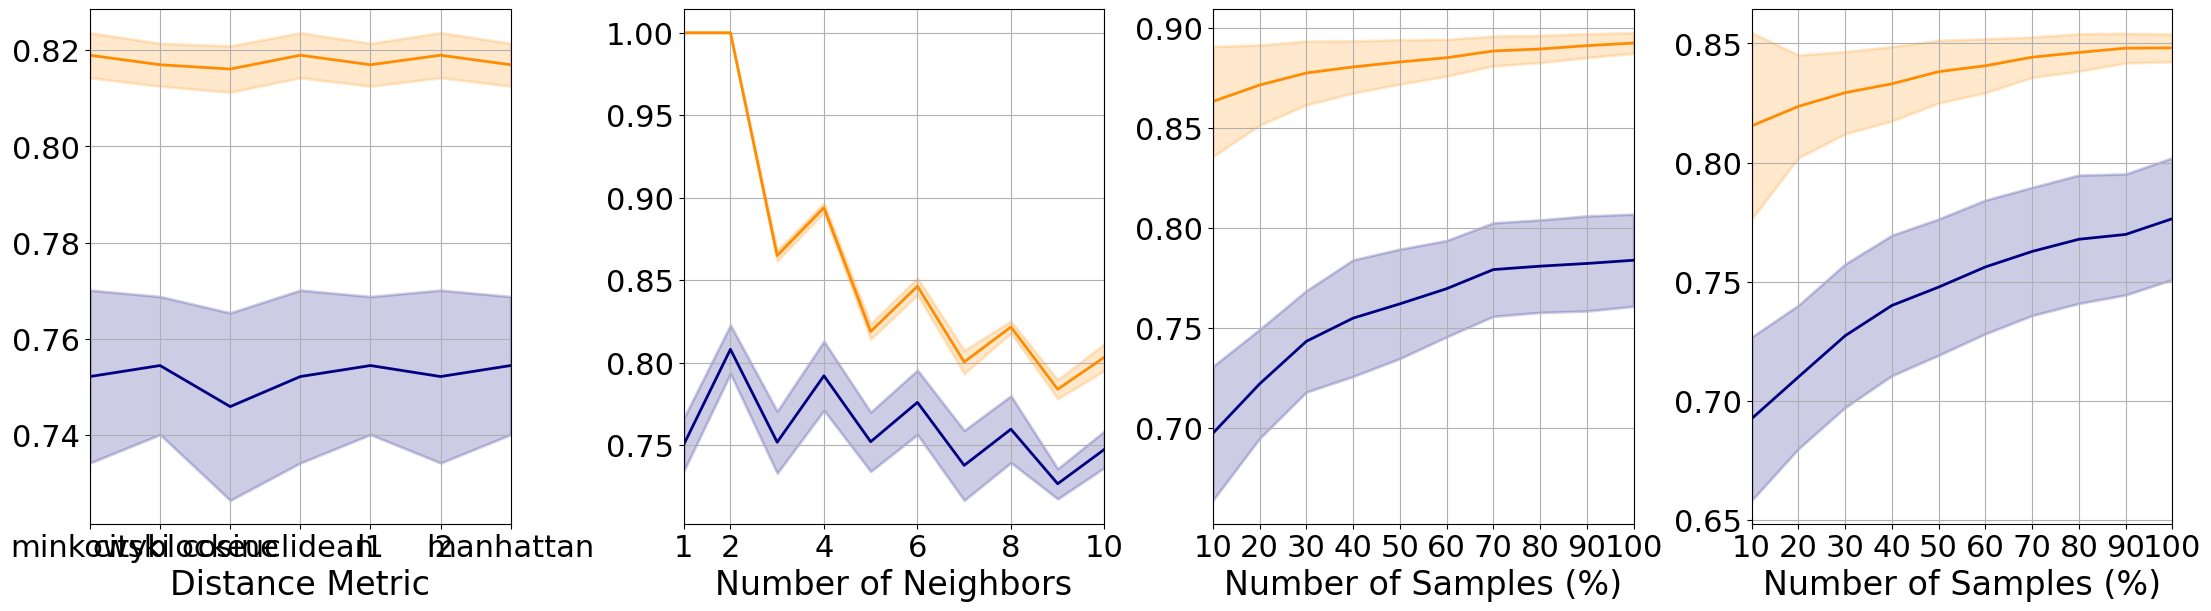

In [32]:
# initialize plot
bio_fig, bio_axs = plt.subplots(1, 4, constrained_layout=True)
bio_fig.set_size_inches(22, 6)

# distance metric
knn_metric_name=['Distance Metric', 'metric']
knn_metric_range=['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
knn_metric_range_labels=['mink', 'cb', 'cos', 'euc', 'l1', 'l2', 'man']
knn_bio_metric = plot_validation_curve(KNeighborsClassifier(), bio_train_x, bio_train_y, param_name=knn_metric_name, param_range=knn_metric_range, scoring=precision_scoring, ax=bio_axs[0])

# number of neighbors
knn_nn_name=['Number of Neighbors', 'n_neighbors']
knn_nn_range=range(1,11)
knn_bio_nn = plot_validation_curve(KNeighborsClassifier(), bio_train_x, bio_train_y, param_name=knn_nn_name, param_range=knn_nn_range, scoring=precision_scoring, ax=bio_axs[1])

# learning curves
knn_bio_lc = plot_learning_curve(KNeighborsClassifier(n_neighbors=4, metric='cityblock'), bio_train_x, bio_train_y, precision_scoring, ax=bio_axs[2])
knn_bio_lc_tuned = plot_learning_curve(KNeighborsClassifier(n_neighbors=6, metric='cityblock'), bio_train_x, bio_train_y, precision_scoring, ax=bio_axs[3])

### Export Plot

In [33]:
# title and subplot titles
bio_fig.suptitle('Bioresponse Curves for K-Nearest Neighbors Classifier',fontsize=fs+4)
bio_axs[0].set_title('(a)',fontsize=fs+2)
bio_axs[1].set_title('(b)',fontsize=fs+2)
bio_axs[2].set_title('(c)',fontsize=fs+2)
bio_axs[3].set_title('(d)',fontsize=fs+2)

# x limits and labels
bio_axs[0].set_xticklabels(knn_metric_range_labels)
bio_axs[2].set_xticks([240,  480,  960, 1440, 1920, 2400])
bio_axs[2].set_xlim(240, 2400)
bio_axs[3].set_xticks([240,  480,  960, 1440, 1920, 2400])
bio_axs[3].set_xlim(240, 2400)

# y limits and labels
plt.setp(bio_axs, ylim=[0.6,1.005])
bio_axs[0].set_ylabel('Precision', fontsize=fs+2)
bio_axs[1].tick_params(labelleft=False, left=False)
bio_axs[2].tick_params(labelleft=False, left=False)
bio_axs[3].tick_params(labelleft=False, left=False)

# legend and save
bio_axs[3].legend(loc="best", fontsize=fs)
plt.show()

C:\Users\lenni\AppData\Local\Temp\ipykernel_42272\4242073460.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  bio_axs[0].set_xticklabels(knn_metric_range_labels)


##  Letter

In [ ]:
# initialize plot
letter_fig, letter_axs = plt.subplots(2, 4, constrained_layout=True)
letter_fig.set_size_inches(20,14)

# number of neighbors
knn_letter_nn = plot_validation_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, param_name=knn_nn_name, param_range=range(1,21), scoring=mcc_scoring, ax=letter_axs[0,1])
knn_letter_nn_roc = plot_validation_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, param_name=knn_nn_name, param_range=range(1,21), scoring=rocauc_scoring, ax=letter_axs[1,1])
knn_nn_letter_best= [range(1,21)[np.argmax(np.mean(knn_letter_nn[1],axis=1))], range(1,21)[np.argmax(np.mean(knn_letter_nn_roc[1],axis=1))]]

# distance metric
knn_letter_metric = plot_validation_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, param_name=knn_metric_name, param_range=knn_metric_range, scoring=mcc_scoring, ax=letter_axs[0,0])
knn_letter_metric_roc = plot_validation_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, param_name=knn_metric_name, param_range=knn_metric_range, scoring=rocauc_scoring, ax=letter_axs[1,0])
knn_metric_letter_best= [knn_metric_range[np.argmax(np.mean(knn_letter_metric[1],axis=1))], knn_metric_range[np.argmax(np.mean(knn_letter_metric_roc[1],axis=1))]]

# learning curves
knn_letter_lc = plot_learning_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, mcc_scoring, ax=letter_axs[0,2])
knn_letter_lc_roc = plot_learning_curve(KNeighborsClassifier(), letter_train_x, letter_train_y, rocauc_scoring, ax=letter_axs[1,2])
knn_letter_lc_tuned = plot_learning_curve(KNeighborsClassifier(n_neighbors=15), letter_train_x, letter_train_y, mcc_scoring, ax=letter_axs[0,3])
knn_letter_lc_roc_tuned = plot_learning_curve(KNeighborsClassifier(n_neighbors=15), letter_train_x, letter_train_y, rocauc_scoring, ax=letter_axs[1,3])

Number of Neighbors time: 442.8330008983612
Number of Neighbors time: 472.93800020217896


### Plot

In [305]:
# titles
letter_fig.suptitle('Letter Curves for K-Nearest Neighbors Classifier',fontsize=fs+4)
letter_axs[0,0].set_title('(a)',fontsize=fs+2)
letter_axs[0,1].set_title('(b)',fontsize=fs+2)
letter_axs[0,2].set_title('(c)',fontsize=fs+2)
letter_axs[0,3].set_title('(d)',fontsize=fs+2)
letter_axs[1,0].set_title('(e)',fontsize=fs+2)
letter_axs[1,1].set_title('(f)',fontsize=fs+2)
letter_axs[1,2].set_title('(g)',fontsize=fs+2)
letter_axs[1,3].set_title('(h)',fontsize=fs+2)

# x labels
letter_axs[1,0].set_xticklabels(knn_metric_range_labels)
letter_axs[0,0].set_xlabel(None)
letter_axs[0,1].set_xlabel(None)
letter_axs[0,2].set_xlabel(None)
letter_axs[0,3].set_xlabel(None)

letter_axs[0,1].set_xticks([1,5,10,15,20])
letter_axs[1,1].set_xticks([1,5,10,15,20])

letter_axs[0,2].set_xticks([ 1280, 3840,  6400, 8960, 11520])
letter_axs[0,2].set_xlim(1280, 12800)
letter_axs[1,2].set_xticks([ 1280, 3840,  6400, 8960, 11520])
letter_axs[1,2].set_xlim(1280, 12800)
letter_axs[0,3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
letter_axs[0,3].set_xlim(1280, 12800)
letter_axs[1,3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
letter_axs[1,3].set_xlim(1280, 12800)

# y limits and labels
letter_axs[0,0].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
letter_axs[1,0].set_ylabel('Area Under ROC Curve', fontsize=fs+2)
letter_axs[0,0].tick_params(labelbottom=False, bottom=False)
letter_axs[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
letter_axs[0,2].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
letter_axs[0,3].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
letter_axs[1,1].tick_params(labelleft=False, left=False)
letter_axs[1,2].tick_params(labelleft=False, left=False)
letter_axs[1,3].tick_params(labelleft=False, left=False)

letter_axs[0,0].set_ylim(0.7, 1)
letter_axs[0,1].set_ylim(0.7, 1)
letter_axs[0,2].set_ylim(0.7, 1)
letter_axs[0,3].set_ylim(0.7, 1)
letter_axs[1,0].set_ylim(0.95, 1.005)
letter_axs[1,1].set_ylim(0.95, 1.005)
letter_axs[1,2].set_ylim(0.95, 1.005)
letter_axs[1,3].set_ylim(0.95, 1.005)

# legend and save
letter_axs[0,3].legend(loc="best", fontsize=fs)
plt.show()

C:\Users\lenni\AppData\Local\Temp\ipykernel_15496\978624964.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  letter_axs[1,0].set_xticklabels(knn_metric_range_labels)


# Support Vector Machines

sklearn.svm.[SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

In [306]:
from sklearn import svm

## Bio and Letter Validation Curves

In [311]:
# initialize plot
svm_fig, svm_axs = plt.subplots(2, 4, constrained_layout=True)
svm_fig.set_size_inches(20,14)

# kernel type
svm_kernel_name=['Kernel Type', 'kernel']
svm_kernel_range=['linear', 'poly', 'rbf', 'sigmoid']

svm_bio_kernel = plot_validation_curve(svm.SVC(random_state=42), bio_train_x, bio_train_y, param_name=svm_kernel_name, param_range=svm_kernel_range, scoring=precision_scoring, ax=svm_axs[0,0])
svm_letter_kernel = plot_validation_curve(svm.SVC(random_state=42), letter_train_x, letter_train_y, param_name=svm_kernel_name, param_range=svm_kernel_range, scoring=mcc_scoring, ax=svm_axs[1,0])

# coefficient 0
svm_c0_name=['Coef0', 'coef0']
svm_c0_range=[0.1,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10]

svm_bio_c0 = plot_validation_curve(svm.SVC(random_state=42,kernel='poly'), bio_train_x, bio_train_y, param_name=svm_c0_name, param_range=svm_c0_range, scoring=precision_scoring, ax=svm_axs[0,1])
svm_letter_c0 = plot_validation_curve(svm.SVC(random_state=42, kernel='poly'), letter_train_x, letter_train_y, param_name=svm_c0_name, param_range=svm_c0_range, scoring=mcc_scoring, ax=svm_axs[1,1])

# C
svm_c_name=['C', 'C']
svm_c_range=[0.1,0.5,0.75,1,1.25,1.5,2,3,4,5]

svm_bio_c = plot_validation_curve(svm.SVC(random_state=42,kernel='poly'), bio_train_x, bio_train_y, param_name=svm_c_name, param_range=svm_c_range, scoring=precision_scoring, ax=svm_axs[0,2])
svm_letter_c = plot_validation_curve(svm.SVC(random_state=42, kernel='poly'), letter_train_x, letter_train_y, param_name=svm_c_name, param_range=svm_c_range, scoring=mcc_scoring, ax=svm_axs[1,2])

# degree
svm_dg_name=['Degree', 'degree']
svm_dg_range=range(0,5)

svm_bio_dg = plot_validation_curve(svm.SVC(random_state=42,kernel='poly'), bio_train_x, bio_train_y, param_name=svm_dg_name, param_range=svm_dg_range, scoring=precision_scoring, ax=svm_axs[0,3])
svm_letter_dg = plot_validation_curve(svm.SVC(random_state=42, kernel='poly'), letter_train_x, letter_train_y, param_name=svm_dg_name, param_range=svm_dg_range, scoring=mcc_scoring, ax=svm_axs[1,3])

### Plot

In [320]:
# titles
svm_fig.suptitle('Bioresponse and Letter Validation Curves for Support Vector Machine Classifier',fontsize=fs+4)
svm_axs[0,0].set_title('(a)',fontsize=fs+2)
svm_axs[0,1].set_title('(b)',fontsize=fs+2)
svm_axs[0,2].set_title('(c)',fontsize=fs+2)
svm_axs[0,3].set_title('(d)',fontsize=fs+2)
svm_axs[1,0].set_title('(e)',fontsize=fs+2)
svm_axs[1,1].set_title('(f)',fontsize=fs+2)
svm_axs[1,2].set_title('(g)',fontsize=fs+2)
svm_axs[1,3].set_title('(h)',fontsize=fs+2)

# x labels
#letter_axs[1,0].set_xticklabels(knn_metric_range_labels)
svm_axs[0,0].set_xlabel(None)
svm_axs[0,1].set_xlabel(None)
svm_axs[0,2].set_xlabel(None)
svm_axs[0,3].set_xlabel(None)

svm_axs[0,1].set_xticks([0.1,2,4,6,8,10])
svm_axs[0,1].set_xticklabels([0.1,2,4,6,8,10])
svm_axs[1,1].set_xticks([0.1,2,4,6,8,10])
svm_axs[1,1].set_xticklabels([0.1,2,4,6,8,10])
svm_axs[0,2].set_xticks([0.1,1,2,3,4,5])
svm_axs[0,2].set_xticklabels([0.1,1,2,3,4,5])
svm_axs[1,2].set_xticks([0.1,1,2,3,4,5])
svm_axs[1,2].set_xticklabels([0.1,1,2,3,4,5])
svm_axs[0,3].set_xticks([0,1,2,3,4])
svm_axs[1,3].set_xticks([0,1,2,3,4])

# y limits and labels
svm_axs[0,0].set_ylabel('Precision', fontsize=fs+2)
svm_axs[1,0].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
svm_axs[0,0].tick_params(labelbottom=False, bottom=False)
svm_axs[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
svm_axs[0,2].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
svm_axs[0,3].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
svm_axs[1,1].tick_params(labelleft=False, left=False)
svm_axs[1,2].tick_params(labelleft=False, left=False)
svm_axs[1,3].tick_params(labelleft=False, left=False)

svm_axs[0,0].set_ylim(0.7, 1)
svm_axs[0,1].set_ylim(0.7, 1)
svm_axs[0,2].set_ylim(0.7, 1)
svm_axs[0,3].set_ylim(0.7, 1)
svm_axs[1,0].set_ylim(0.6, 1)
svm_axs[1,1].set_ylim(0.6, 1)
svm_axs[1,2].set_ylim(0.6, 1)
svm_axs[1,3].set_ylim(0.6, 1)

# legend and save
svm_axs[0,3].legend(loc="best", fontsize=fs)
plt.savefig('svm_vc.png',dpi=200)

## Learning Curves

In [375]:
# initialize plot
svm_lc_fig, svm_lc_axs = plt.subplots(1, 4, constrained_layout=True)
svm_lc_fig.set_size_inches(20,6)

# bio learning curves
svm_bio_lc = plot_learning_curve(svm.SVC(random_state=42, kernel='poly', coef0=0.1, C=4, degree=1), bio_train_x, bio_train_y, precision_scoring, ax=svm_lc_axs[0])
svm_bio_lc_tuned = plot_learning_curve(svm.SVC(random_state=42, kernel='poly', coef0=0.1, C=0.5, degree=1), bio_train_x, bio_train_y, precision_scoring, ax=svm_lc_axs[1])

# letter learning curves
svm_letter_lc = plot_learning_curve(svm.SVC(random_state=42, kernel='poly', C=0.5,degree=4), letter_train_x, letter_train_y, mcc_scoring, ax=svm_lc_axs[2])
svm_letter_lc_tuned = plot_learning_curve(svm.SVC(random_state=42, kernel='poly', C=0.5,degree=2), letter_train_x, letter_train_y, mcc_scoring, ax=svm_lc_axs[3])

### Plot

In [1440]:
# title and subplot titles
svm_lc_fig.suptitle('Learning Curves for Support Vector Machine Classifier',fontsize=fs+4)
svm_lc_axs[0].set_title('(a)',fontsize=fs+2)
svm_lc_axs[1].set_title('(b)',fontsize=fs+2)
svm_lc_axs[2].set_title('(c)',fontsize=fs+2)
svm_lc_axs[3].set_title('(d)',fontsize=fs+2)

# x labels
#knn_axs[0].set_xticklabels(knn_metric_range_labels)
svm_lc_axs[0].set_xticks([240,  480,  960, 1440, 1920, 2400])
svm_lc_axs[0].set_xlim(240, 2400)
svm_lc_axs[1].set_xticks([240,  480,  960, 1440, 1920, 2400])
svm_lc_axs[1].set_xlim(240, 2400)
svm_lc_axs[2].set_xticks([ 1280, 3840,  6400, 8960, 11520])
svm_lc_axs[2].set_xlim(1280, 12800)
svm_lc_axs[3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
svm_lc_axs[3].set_xlim(1280, 12800)

# y limits and labels
svm_lc_axs[0].set_ylabel('Precision', fontsize=fs+2)
svm_lc_axs[1].tick_params(labelleft=False, left=False)
svm_lc_axs[0].set_ylim(0.6, 1)
svm_lc_axs[1].set_ylim(0.6, 1)
svm_lc_axs[2].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
svm_lc_axs[3].tick_params(labelleft=False, left=False)
svm_lc_axs[2].set_ylim(0.75, 1)
svm_lc_axs[3].set_ylim(0.75, 1)

# legend and save
svm_lc_axs[1].legend(loc="best", fontsize=fs)
svm_lc_axs[3].legend(loc="best", fontsize=fs)
plt.savefig('svm_lc.png',dpi=200)

# Neural Nets

sklearn.neural_network.[MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [111]:
from sklearn.neural_network import MLPClassifier
nn_clf =['Neural Net', MLPClassifier(random_state=42,max_iter=1000,early_stopping=True)]

## Validation and Learning Curves

In [ ]:
# initialize plot
nn_vc_fig, nn_vc_axs = plt.subplots(2, 4, constrained_layout=True)
nn_vc_fig.set_size_inches(20, 14)

# hidden layer sizes
nn_hl_name=['First Layer Width', 'hidden_layer_sizes']
nn_hl_range=[3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

nn_bio_hl = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                      bio_train_x, bio_train_y, param_name = nn_hl_name, param_range =nn_hl_range, scoring = precision_scoring, ax=nn_vc_axs[0,0])

nn_letter_hl = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                     letter_train_x, letter_train_y, param_name=nn_hl_name, param_range=nn_hl_range, scoring=mcc_scoring, ax=nn_vc_axs[1,0])

# activation function
nn_af_name=['Activation Function', 'activation']
nn_af_range=['identity', 'logistic', 'tanh', 'relu']

nn_bio_af = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                  bio_train_x, bio_train_y, param_name=nn_af_name, param_range=nn_af_range, scoring=precision_scoring, ax=nn_vc_axs[0,1])

nn_letter_af = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                     letter_train_x, letter_train_y, param_name=nn_af_name, param_range=nn_af_range, scoring=mcc_scoring, ax=nn_vc_axs[1,1])

# solver
nn_solver_name=['Solver', 'solver']
nn_solver_range=['lbfgs', 'sgd', 'adam']

nn_bio_solver = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                      bio_train_x, bio_train_y, param_name=nn_solver_name, param_range=nn_solver_range, scoring=precision_scoring, ax=nn_vc_axs[0,2])
nn_letter_solver = plot_validation_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True),
                                         letter_train_x, letter_train_y, param_name=nn_solver_name, param_range=nn_solver_range, scoring=mcc_scoring, ax=nn_vc_axs[1,2])

# learning curves
nn_bio_lc = plot_learning_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True, solver='sgd', activation='relu', hidden_layer_sizes=(80,)), 
                                bio_train_x, bio_train_y, precision_scoring, ax=nn_vc_axs[0,3])
nn_letter_lc = plot_learning_curve(MLPClassifier(random_state=42,max_iter=2000,early_stopping=True, solver='adam', activation='tanh', hidden_layer_sizes=(100,)),  
                                letter_train_x, letter_train_y, mcc_scoring, ax=nn_vc_axs[1,3])

### Plot

In [ ]:
# titles
nn_vc_fig.suptitle('Bioresponse and Letter Validation and Learning Curves for Neural Network Classifier',fontsize=fs+4)
nn_vc_axs[0,0].set_title('(a)',fontsize=fs+2)
nn_vc_axs[0,1].set_title('(b)',fontsize=fs+2)
nn_vc_axs[0,2].set_title('(c)',fontsize=fs+2)
nn_vc_axs[0,3].set_title('(d)',fontsize=fs+2)
nn_vc_axs[1,0].set_title('(e)',fontsize=fs+2)
nn_vc_axs[1,1].set_title('(f)',fontsize=fs+2)
nn_vc_axs[1,2].set_title('(g)',fontsize=fs+2)
nn_vc_axs[1,3].set_title('(h)',fontsize=fs+2)

# x labels
nn_vc_axs[0,0].set_xlabel(None)
nn_vc_axs[0,1].set_xlabel(None)
nn_vc_axs[0,2].set_xlabel(None)
nn_vc_axs[0,3].set_xlabel(None)

nn_vc_axs[0,3].set_xticks([240,  480,  960, 1440, 1920, 2400])
nn_vc_axs[0,3].set_xlim(240, 2400)
nn_vc_axs[1,3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
nn_vc_axs[1,3].set_xlim(1280, 12800)


# y limits and labels
nn_vc_axs[0,0].set_ylabel('Precision', fontsize=fs+2)#
nn_vc_axs[1,0].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)
nn_vc_axs[0,0].tick_params(labelbottom=False, bottom=False)
nn_vc_axs[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
nn_vc_axs[0,2].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
nn_vc_axs[0,3].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
nn_vc_axs[1,1].tick_params(labelleft=False, left=False)
nn_vc_axs[1,2].tick_params(labelleft=False, left=False)
nn_vc_axs[1,3].tick_params(labelleft=False, left=False)

nn_vc_axs[0,0].set_ylim(0.6, 1)
nn_vc_axs[0,1].set_ylim(0.6, 1)
nn_vc_axs[0,2].set_ylim(0.6, 1)
nn_vc_axs[0,3].set_ylim(0.6, 1)
nn_vc_axs[1,0].set_ylim(0.6, 1)
nn_vc_axs[1,1].set_ylim(0.6, 1)
nn_vc_axs[1,2].set_ylim(0.6, 1)
nn_vc_axs[1,3].set_ylim(0.6, 1)

# legend and save
nn_vc_axs[0,3].legend(loc="best", fontsize=fs)
plt.show()

## Loss Curves

In [172]:
# initialize plot
nn_lc_fig, nn_lc_axs = plt.subplots(1, 2, constrained_layout=True)
nn_lc_fig.set_size_inches(16, 10)

# fit best bio neural network classifier
nn_bio_best = MLPClassifier(random_state=42,max_iter=2000,early_stopping=True, solver='adam', activation='tanh', hidden_layer_sizes=(100,))
nn_bio_best.fit(bio_train_x, bio_train_y)

# calculate loss per iteration
nn_bio_loss = nn_bio_best.loss_curve_
nn_bio_loss_iterations = range(1,len(nn_bio_loss)+1)

# plot
nn_lc_axs[0].plot(nn_bio_loss_iterations, nn_bio_loss, color='darkorange', lw=2)
nn_lc_axs[0].set_xlabel('Iterations', fontsize=24)
nn_lc_axs[0].set_xlim(1,max(nn_bio_loss_iterations))
nn_lc_axs[0].set_ylabel('Loss', fontsize=fs+2)
nn_lc_axs[0].tick_params(labelsize=fs)
nn_lc_axs[0].grid()

In [174]:
# fit best letter neural network classifier
nn_letter_best = MLPClassifier(random_state=42,max_iter=2000,early_stopping=True, solver='adam', activation='tanh', hidden_layer_sizes=(100,))
nn_letter_best.fit(letter_train_x, letter_train_y)

# calculate loss per iteration
nn_letter_loss = nn_letter_best.loss_curve_
nn_letter_loss_iterations = range(1,len(nn_letter_loss)+1)

# plot
nn_lc_axs[1].plot(nn_letter_loss_iterations, nn_letter_loss, color='darkorange', lw=2)
nn_lc_axs[1].set_xlabel('Iterations', fontsize=fs+2)
nn_lc_axs[1].set_xlim(1,max(nn_letter_loss_iterations))
nn_lc_axs[1].set_ylabel('Loss', fontsize=fs+2)
nn_lc_axs[1].tick_params(labelsize=fs)
nn_lc_axs[1].grid()

### Plot

In [175]:
nn_lc_fig.suptitle('Loss Curves for Neural Network Classifier',fontsize=fs+4)
plt.show()

# Boosting

sklearn.ensemble.[AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn-ensemble-adaboostclassifier)

In [12]:
from sklearn.ensemble import AdaBoostClassifier

## Bio Curves

In [15]:
# initialize plot
ada_bio_fig, ada_bio_axs = plt.subplots(1, 4, constrained_layout=True)
ada_bio_fig.set_size_inches(20,6)

# number of estimators
ada_nest_name=['Number of Estimators', 'n_estimators']
ada_nest_range=range(1,30)
ada_bio_nest = plot_validation_curve(AdaBoostClassifier(random_state=42), bio_train_x, bio_train_y, param_name=ada_nest_name, param_range=ada_nest_range, scoring=precision_scoring, ax=ada_bio_axs[0])

# learning rate
ada_lr_name=['Learning Rate', 'learning_rate']
ada_lr_range=np.arange(0,1,0.05)
ada_bio_lr = plot_validation_curve(AdaBoostClassifier(random_state=42), bio_train_x, bio_train_y, param_name=ada_lr_name, param_range=ada_lr_range, scoring=precision_scoring, ax=ada_bio_axs[1])

# learning curves
ada_bio_lc = plot_learning_curve(AdaBoostClassifier(random_state=42), bio_train_x, bio_train_y, precision_scoring, ax=ada_bio_axs[2])
ada_bio_lc_tuned = plot_learning_curve(AdaBoostClassifier(random_state=42, n_estimators=7, learning_rate=0.8), bio_train_x, bio_train_y, precision_scoring, ax=ada_bio_axs[3])

### Plot

In [ ]:
# title and subplot titles
ada_bio_fig.suptitle('Bioresponse Curves for Adaboost Classifier',fontsize=fs+4)
ada_bio_axs[0].set_title('(a)',fontsize=fs+2)
ada_bio_axs[1].set_title('(b)',fontsize=fs+2)
ada_bio_axs[2].set_title('(c)',fontsize=fs+2)
ada_bio_axs[3].set_title('(d)',fontsize=fs+2)

# x labels
ada_bio_axs[1].set_xlim(0.5,0.95)
ada_bio_axs[2].set_xticks([240,  480,  960, 1440, 1920, 2400])
ada_bio_axs[2].set_xlim(240, 2400)
ada_bio_axs[3].set_xticks([240,  480,  960, 1440, 1920, 2400])
ada_bio_axs[3].set_xlim(240, 2400)

# y limits and labels
plt.setp(ada_bio_axs, ylim=[0.65,1])
ada_bio_axs[0].set_ylabel('Precision', fontsize=fs+2)
ada_bio_axs[1].tick_params(labelleft=False, left=False)
ada_bio_axs[2].tick_params(labelleft=False, left=False)
ada_bio_axs[3].tick_params(labelleft=False, left=False)

# legend and save
ada_bio_axs[3].legend(loc="best", fontsize=fs)
plt.show()

## Letter

In [17]:
# initialize plot
ada_letter_fig, ada_letter_axs = plt.subplots(2, 4, constrained_layout=True)
ada_letter_fig.set_size_inches(20,14)

# number of estimators
ada_letter_nest = plot_validation_curve(AdaBoostClassifier(random_state=42), letter_train_x, letter_train_y, param_name=ada_nest_name, param_range=range(5,40), scoring=mcc_scoring, ax=ada_letter_axs[0,0])
ada_letter_nest_roc = plot_validation_curve(AdaBoostClassifier(random_state=42), letter_train_x, letter_train_y, param_name=ada_nest_name, param_range=range(5,40), scoring=rocauc_scoring, ax=ada_letter_axs[1,0])
ada_letter_nest_best = range(5,40)[np.argmax(np.mean(ada_letter_nest[1],axis=1))]

# learning rate
ada_letter_lr = plot_validation_curve(AdaBoostClassifier(random_state=42), letter_train_x, letter_train_y, param_name=ada_lr_name, param_range=ada_lr_range, scoring=mcc_scoring, ax=ada_letter_axs[0,1])
ada_letter_lr_roc = plot_validation_curve(AdaBoostClassifier(random_state=42), letter_train_x, letter_train_y, param_name=ada_lr_name, param_range=ada_lr_range, scoring=rocauc_scoring, ax=ada_letter_axs[1,1])
ada_letter_lr_best = ada_lr_range[np.argmax(np.mean(ada_letter_lr[1],axis=1))]

# learning curve
ada_letter_lc = plot_learning_curve(AdaBoostClassifier(random_state=42), letter_train_x, letter_train_y, mcc_scoring, ax=ada_letter_axs[0,2])
ada_letter_lc_roc = plot_learning_curve(AdaBoostClassifier(random_state=42), letter_train_x, letter_train_y, rocauc_scoring, ax=ada_letter_axs[1,2])

ada_letter_lc_tuned = plot_learning_curve(AdaBoostClassifier(random_state=42, learning_rate=ada_letter_lr_best, n_estimators=ada_letter_nest_best),
                                    letter_train_x, letter_train_y, mcc_scoring, ax=ada_letter_axs[0,3])
ada_letter_lc_roc_tuned = plot_learning_curve(AdaBoostClassifier(random_state=42, learning_rate=ada_letter_lr_best, n_estimators=ada_letter_nest_best),
                                        letter_train_x, letter_train_y, rocauc_scoring, ax=ada_letter_axs[1,3])

### Plot

In [55]:
# titles
ada_letter_fig.suptitle('Letter Curves for Adaboost Classifier',fontsize=fs+4)
ada_letter_axs[0,0].set_title('(a)',fontsize=fs+2)
ada_letter_axs[0,1].set_title('(b)',fontsize=fs+2)
ada_letter_axs[0,2].set_title('(c)',fontsize=fs+2)
ada_letter_axs[0,3].set_title('(d)',fontsize=fs+2)
ada_letter_axs[1,0].set_title('(e)',fontsize=fs+2)
ada_letter_axs[1,1].set_title('(f)',fontsize=fs+2)
ada_letter_axs[1,2].set_title('(g)',fontsize=fs+2)
ada_letter_axs[1,3].set_title('(h)',fontsize=fs+2)

# x labels
ada_letter_axs[0,0].set_xlabel(None)
ada_letter_axs[0,1].set_xlabel(None)
ada_letter_axs[0,2].set_xlabel(None)
ada_letter_axs[0,3].set_xlabel(None)

ada_letter_axs[0,1].set_xlim(0.1,0.9)
ada_letter_axs[1,1].set_xlim(0.1,0.9)
ada_letter_axs[0,2].set_xticks([ 1280, 3840,  6400, 8960, 11520])
ada_letter_axs[0,2].set_xlim(1280, 12800)
ada_letter_axs[1,2].set_xticks([ 1280, 3840,  6400, 8960, 11520])
ada_letter_axs[1,2].set_xlim(1280, 12800)
ada_letter_axs[0,3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
ada_letter_axs[0,3].set_xlim(1280, 12800)
ada_letter_axs[1,3].set_xticks([ 1280, 3840,  6400, 8960, 11520])
ada_letter_axs[1,3].set_xlim(1280, 12800)

# y limits and labels
ada_letter_axs[0,0].set_ylabel('Matthew Correlation Coefficient', fontsize=fs+2)#
ada_letter_axs[1,0].set_ylabel('Area Under ROC Curve', fontsize=fs+2)
ada_letter_axs[0,0].tick_params(labelbottom=False, bottom=False)
ada_letter_axs[0,1].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
ada_letter_axs[0,2].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
ada_letter_axs[0,3].tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
ada_letter_axs[1,1].tick_params(labelleft=False, left=False)
ada_letter_axs[1,2].tick_params(labelleft=False, left=False)
ada_letter_axs[1,3].tick_params(labelleft=False, left=False)

ada_letter_axs[0,0].set_ylim(0, 0.4)
ada_letter_axs[0,1].set_ylim(0, 0.4)
ada_letter_axs[0,2].set_ylim(0, 0.4)
ada_letter_axs[0,3].set_ylim(0, 0.4)
ada_letter_axs[1,0].set_ylim(0.6, 1)
ada_letter_axs[1,1].set_ylim(0.6, 1)
ada_letter_axs[1,2].set_ylim(0.6, 1)
ada_letter_axs[1,3].set_ylim(0.6, 1)

# legend and save
ada_letter_axs[0,3].legend(loc="best", fontsize=fs)
plt.show()